In [1]:
from matplotlib import pylab
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(context='poster', style='dark')

pylab.rcParams['figure.figsize'] = (24.0, 18.0)

import numpy as np
from numpy.random import rand
import pandas as pd

from sklearn import cross_validation
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import time

In [2]:
def try_model(X, Y, model):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.2, random_state=10)

    print("start fitting... ", time.ctime().split()[3])
    model.fit(X_train, y_train)
    print("done fitting... ", time.ctime().split()[3])

    mse = mean_squared_error(y_test, model.predict(X_test))
    print('mean squared error: ', mse)

    print("explained variance score: ", explained_variance_score(np.abs(y_test), np.abs(model.predict(X_test))))

In [2]:
#importing and munging the data

#importing providers_info
providers_info = pd.read_csv('providers.csv')
providers_info = providers_info[0:2884]                          # removing NA values at the end
providers_info.columns = ['practice_id', 'provider_id', 'specialty', 'provider_level', 'tenure']

key_id = providers_info.practice_id + providers_info.provider_id / 100

# print key_id

providers_info['key_id'] = key_id
providers_info = providers_info[['key_id', 'practice_id', 'provider_id', 'specialty', 'provider_level', 'tenure']]

# providers_info.head(50)

# importing work_data

work_data = pd.read_csv('work.csv')
work_data = work_data[0:29974]
work_data.columns = ['practice_id', 'provider_id', 'obs_month', 'variable', 'value']

key_id = work_data.practice_id + work_data.provider_id / 100

work_data['key_id'] = key_id

work_data_nested = work_data.set_index(['practice_id', 'provider_id', 'obs_month', 'variable', 'key_id']).unstack('variable')
work_data = pd.DataFrame(work_data_nested.reset_index())
work_data = work_data.rename(columns = {'value': 'work_vals'})

# work_data.head()

#importing emr_touches and adding to global_df

emr_touches = pd.read_csv('emr_touches.csv')
emr_touches = emr_touches[0:14987]
emr_touches.columns = ['practice_id', 'provider_id', 'obs_month', 'keystrokes', 'mousestrokes']

# emr_touches.tail(10)

global_df = emr_touches
global_df['encounters'] = work_data.work_vals.Encounters
global_df['RVUs'] = work_data.work_vals.RVUs

# global_df.tail(10)

#importing emr_time

emr_time = pd.read_csv('emr_time.csv')
emr_time = emr_time[0:59948]

emr_time.columns = ['practice_id', 'provider_id', 'obs_month', 'variable', 'value']
emr_time_nested = emr_time.set_index(['practice_id', 'provider_id', 'obs_month', 'variable']).unstack('variable')

emr_time = pd.DataFrame(emr_time_nested.reset_index())
emr_time = emr_time.rename(columns = {'value': 'EMR_time'})

global_df['exam_emr'] = emr_time.EMR_time['Time Exam']
global_df['intake_emr'] = emr_time.EMR_time['Time Intake']
global_df['postvisit_emr'] = emr_time.EMR_time['Time Postvisit']
global_df['signoff_emr'] = emr_time.EMR_time['Time Signoff']
global_df['key_id'] = global_df.practice_id + global_df.provider_id / 100

#final merge
temp_df = global_df
total_df = pd.merge(temp_df[['key_id','obs_month', 'keystrokes', 'mousestrokes', 'encounters', 'RVUs', 'exam_emr', 'intake_emr',\
                             'postvisit_emr', 'signoff_emr']], providers_info, on = 'key_id')

#calculating stats

total_df['total_emr'] = total_df.exam_emr + total_df.intake_emr + total_df.postvisit_emr + total_df.signoff_emr
total_df['encounters'] = total_df.encounters.replace(0, np.nan) #replacing encounters = 0 with nan
total_df['grand_mee'] = total_df.total_emr / total_df.encounters # mee = Mean (total_Emr_time / Encounter)
total_df['exam_emr_enc'] = total_df.exam_emr / total_df.encounters
total_df['intake_emr_enc'] = total_df.intake_emr / total_df.encounters
total_df['postvisit_emr_enc'] = total_df.postvisit_emr / total_df.encounters
total_df['signoff_emr_enc'] = total_df.signoff_emr / total_df.encounters

total_df['RVUs_enc'] = total_df.RVUs / total_df.encounters

total_df['key_min'] = total_df.keystrokes / total_df.total_emr
total_df['mouse_min'] = total_df.mousestrokes / total_df.total_emr

total_df['key_enc'] = total_df.keystrokes / total_df.encounters
total_df['mouse_enc'] = total_df.mousestrokes / total_df.encounters

total_df = total_df[['key_id', 'obs_month', 'specialty', 'provider_level', 'grand_mee', 'intake_emr_enc', 'exam_emr_enc', \
                     'postvisit_emr_enc', 'signoff_emr_enc',\
                     'key_min', 'mouse_min', 'key_enc', 'mouse_enc',\
                     'encounters', 'RVUs_enc', 'exam_emr', 'intake_emr', 'postvisit_emr', 'signoff_emr', \
                     'tenure', 'practice_id', 'provider_id', 'keystrokes', 'mousestrokes', 'RVUs', 'total_emr']]
total_df.drop('key_id', 1, inplace=True)
print(total_df.shape)
total_df.head(10)
# total_df.describe()

(15998, 25)


,obs_month,specialty,provider_level,grand_mee,intake_emr_enc,exam_emr_enc,postvisit_emr_enc,signoff_emr_enc,key_min,mouse_min,...,intake_emr,postvisit_emr,signoff_emr,tenure,practice_id,provider_id,keystrokes,mousestrokes,RVUs,total_emr
0,1,PCP,MD,11.122500,0.158102,8.874769,1.702407,0.387222,61.223496,7.693364,...,34.15,367.72,83.64,57,1,1,147087,18483,512.68,2402.46
1,2,PCP,MD,11.544661,0.351873,8.884422,1.986773,0.321594,65.139369,7.520766,...,88.32,498.68,80.72,57,1,1,188755,21793,560.39,2897.71
2,3,PCP,MD,11.730539,0.132963,9.532155,1.860438,0.204983,65.474444,7.550008,...,39.49,552.55,60.88,57,1,1,228111,26304,574.39,3483.97
3,4,PCP,MD,11.111716,0.084067,8.980187,1.866418,0.181045,62.074790,7.396724,...,22.53,500.20,48.52,57,1,1,184855,22027,617.67,2977.94
4,5,PCP,MD,12.033948,0.081255,10.027048,1.707196,0.218450,63.664602,7.725071,...,22.02,462.65,59.20,57,1,1,207623,25193,675.09,3261.20
5,6,PCP,MD,10.320464,0.101750,8.400036,1.567750,0.250929,67.376537,7.602786,...,28.49,438.97,70.26,57,1,1,194700,21970,699.72,2889.73
6,1,PCP,MD,13.838904,0.000000,9.295000,4.459589,0.084315,103.261601,5.133929,...,0.00,651.10,12.31,57,1,2,208638,10373,322.52,2020.48
7,2,PCP,MD,15.011773,0.000000,10.296667,4.502695,0.212411,100.102048,5.297497,...,0.00,634.88,29.95,57,1,2,211882,11213,346.73,2116.66
8,3,PCP,MD,16.074286,0.000000,11.298067,4.651429,0.124790,99.535246,5.501244,...,0.00,553.52,14.85,57,1,2,190395,10523,214.47,1912.84
9,4,PCP,MD,15.386704,0.000000,9.639888,5.705363,0.041453,105.356871,5.058056,...,0.00,1021.26,7.42,57,1,2,290176,13931,305.62,2754.22


In [4]:
total_df.tail()

,obs_month,specialty,provider_level,grand_mee,intake_emr_enc,exam_emr_enc,postvisit_emr_enc,signoff_emr_enc,key_min,mouse_min,...,intake_emr,postvisit_emr,signoff_emr,tenure,practice_id,provider_id,keystrokes,mousestrokes,RVUs,total_emr
15993,2,Surgery,MD,0.229045,0.002611,0.020828,0.205605,0,7.703003,36.985539,...,0.41,32.28,0,30,199,2,277,1330,1038.70,35.96
15994,5,Surgery,MD,0.223832,0.000000,0.000000,0.223832,0,0.428036,35.393258,...,0.00,37.38,0,30,199,2,16,1323,1022.80,37.38
15995,4,Surgery,MD,0.100619,0.000000,0.000000,0.100619,0,4.405738,30.327869,...,0.00,9.76,0,29,199,3,43,296,657.69,9.76
15996,1,Surgery,MD,0.095773,0.000000,0.000000,0.095773,0,0.645856,27.018299,...,0.00,9.29,0,31,199,4,6,251,601.84,9.29
15997,6,Surgery,MD,0.093929,0.000000,0.001905,0.092024,0,0.506971,34.980989,...,0.00,7.73,0,31,199,4,4,276,472.78,7.89


In [5]:
total_df.columns

Index(['obs_month', 'specialty', 'provider_level', 'grand_mee', 'intake_emr_enc', 'exam_emr_enc', 'postvisit_emr_enc', 'signoff_emr_enc', 'key_min', 'mouse_min', 'key_enc', 'mouse_enc', 'encounters', 'RVUs_enc', 'exam_emr', 'intake_emr', 'postvisit_emr', 'signoff_emr', 'tenure', 'practice_id', 'provider_id', 'keystrokes', 'mousestrokes', 'RVUs', 'total_emr'], dtype='object')

In [8]:
naless = total_df.dropna()

In [9]:
naless.shape

(15938, 25)

In [11]:
new_df = pd.get_dummies(naless)
new_df.columns

Index(['obs_month', 'grand_mee', 'intake_emr_enc', 'exam_emr_enc', 'postvisit_emr_enc', 'signoff_emr_enc', 'key_min', 'mouse_min', 'key_enc', 'mouse_enc', 'encounters', 'RVUs_enc', 'exam_emr', 'intake_emr', 'postvisit_emr', 'signoff_emr', 'tenure', 'practice_id', 'provider_id', 'keystrokes', 'mousestrokes', 'RVUs', 'total_emr', 'specialty_Cardiology', 'specialty_OB/GYN', 'specialty_PCP', 'specialty_Surgery', 'provider_level_MD', 'provider_level_Mid-level'], dtype='object')

In [12]:
multiplier = ['specialty_Cardiology', 'specialty_OB/GYN', 'specialty_PCP', 'specialty_Surgery', 'provider_level_MD',\
            'provider_level_Mid-level']
multiplied = ['mouse_enc', 'mouse_min', 'key_enc', 'key_min', 'keystrokes', 'mousestrokes', 'RVUs_enc', 'tenure']

for i in multiplier:
    for j in multiplied:
        new_df['{}_x_{}'.format(i, j)] = new_df[i] * new_df[j]
#         print('{i}_x_{j}'.format(i, j))
#         print(i, "_x_", j, sep="")
        
new_df.columns.values

array(['obs_month', 'grand_mee', 'intake_emr_enc', 'exam_emr_enc',
       'postvisit_emr_enc', 'signoff_emr_enc', 'key_min', 'mouse_min',
       'key_enc', 'mouse_enc', 'encounters', 'RVUs_enc', 'exam_emr',
       'intake_emr', 'postvisit_emr', 'signoff_emr', 'tenure',
       'practice_id', 'provider_id', 'keystrokes', 'mousestrokes', 'RVUs',
       'total_emr', 'specialty_Cardiology', 'specialty_OB/GYN',
       'specialty_PCP', 'specialty_Surgery', 'provider_level_MD',
       'provider_level_Mid-level', 'specialty_Cardiology_x_mouse_enc',
       'specialty_Cardiology_x_mouse_min',
       'specialty_Cardiology_x_key_enc', 'specialty_Cardiology_x_key_min',
       'specialty_Cardiology_x_keystrokes',
       'specialty_Cardiology_x_mousestrokes',
       'specialty_Cardiology_x_RVUs_enc', 'specialty_Cardiology_x_tenure',
       'specialty_OB/GYN_x_mouse_enc', 'specialty_OB/GYN_x_mouse_min',
       'specialty_OB/GYN_x_key_enc', 'specialty_OB/GYN_x_key_min',
       'specialty_OB/GYN_x_keystr

In [8]:
# s1 = 'string 1'
# s2 = 'string 2'

# 'word {}, {}'.format(s1, s2)

In [13]:
cols = ['mouse_enc', 'mouse_min', 'key_enc', 'key_min', 'keystrokes', 'mousestrokes', 'RVUs_enc', 'tenure', \
            'specialty_Cardiology', 'specialty_OB/GYN', 'specialty_PCP', 'specialty_Surgery', 'provider_level_MD',\
            'provider_level_Mid-level',
            'provider_level_Mid-level', 'specialty_Cardiology_x_mouse_enc',
           'specialty_Cardiology_x_mouse_min',
           'specialty_Cardiology_x_key_enc', 'specialty_Cardiology_x_key_min',
           'specialty_Cardiology_x_keystrokes',
           'specialty_Cardiology_x_mousestrokes',
           'specialty_Cardiology_x_RVUs_enc', 'specialty_Cardiology_x_tenure',
           'specialty_OB/GYN_x_mouse_enc', 'specialty_OB/GYN_x_mouse_min',
           'specialty_OB/GYN_x_key_enc', 'specialty_OB/GYN_x_key_min',
           'specialty_OB/GYN_x_keystrokes', 'specialty_OB/GYN_x_mousestrokes',
           'specialty_OB/GYN_x_RVUs_enc', 'specialty_OB/GYN_x_tenure',
           'specialty_PCP_x_mouse_enc', 'specialty_PCP_x_mouse_min',
           'specialty_PCP_x_key_enc', 'specialty_PCP_x_key_min',
           'specialty_PCP_x_keystrokes', 'specialty_PCP_x_mousestrokes',
           'specialty_PCP_x_RVUs_enc', 'specialty_PCP_x_tenure',
           'specialty_Surgery_x_mouse_enc', 'specialty_Surgery_x_mouse_min',
           'specialty_Surgery_x_key_enc', 'specialty_Surgery_x_key_min',
           'specialty_Surgery_x_keystrokes',
           'specialty_Surgery_x_mousestrokes', 'specialty_Surgery_x_RVUs_enc',
           'specialty_Surgery_x_tenure', 'provider_level_MD_x_mouse_enc',
           'provider_level_MD_x_mouse_min', 'provider_level_MD_x_key_enc',
           'provider_level_MD_x_key_min', 'provider_level_MD_x_keystrokes',
           'provider_level_MD_x_mousestrokes', 'provider_level_MD_x_RVUs_enc',
           'provider_level_MD_x_tenure',
           'provider_level_Mid-level_x_mouse_enc',
           'provider_level_Mid-level_x_mouse_min',
           'provider_level_Mid-level_x_key_enc',
           'provider_level_Mid-level_x_key_min',
           'provider_level_Mid-level_x_keystrokes',
           'provider_level_Mid-level_x_mousestrokes',
           'provider_level_Mid-level_x_RVUs_enc',
           'provider_level_Mid-level_x_tenure']

# cols = new_df.drop('grand_mee', 1).columns.values

X = new_df[cols].values
Y = new_df.grand_mee.values
np.shape(X)

(15938, 63)

In [32]:
gbr = GradientBoostingRegressor(verbose=1, n_estimators=1000) # learning_rate=0.01, max_depth=10
# try_model(X, Y, gbr)

In [138]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.2, random_state=10)

gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1          32.7376            1.78m
         2          27.8361            1.45m
         3          23.9191            1.37m
         4          20.5114            1.30m
         5          17.6618            1.27m
         6          15.2851            1.25m
         7          13.2609            1.24m
         8          11.5793            1.21m
         9          10.0864            1.20m
        10           8.8287            1.20m
        20           2.7109            1.11m
        30           1.0878            1.08m
        40           0.5607            1.05m
        50           0.3418            1.03m
        60           0.2336            1.01m
        70           0.1712           59.52s
        80           0.1368           58.46s
        90           0.1135           57.29s
       100           0.0984           56.51s
       200           0.0548           47.63s
       300           0.0405           41.26s
       40

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2, n_estimators=1000,
             random_state=None, subsample=1.0, verbose=1, warm_start=False)

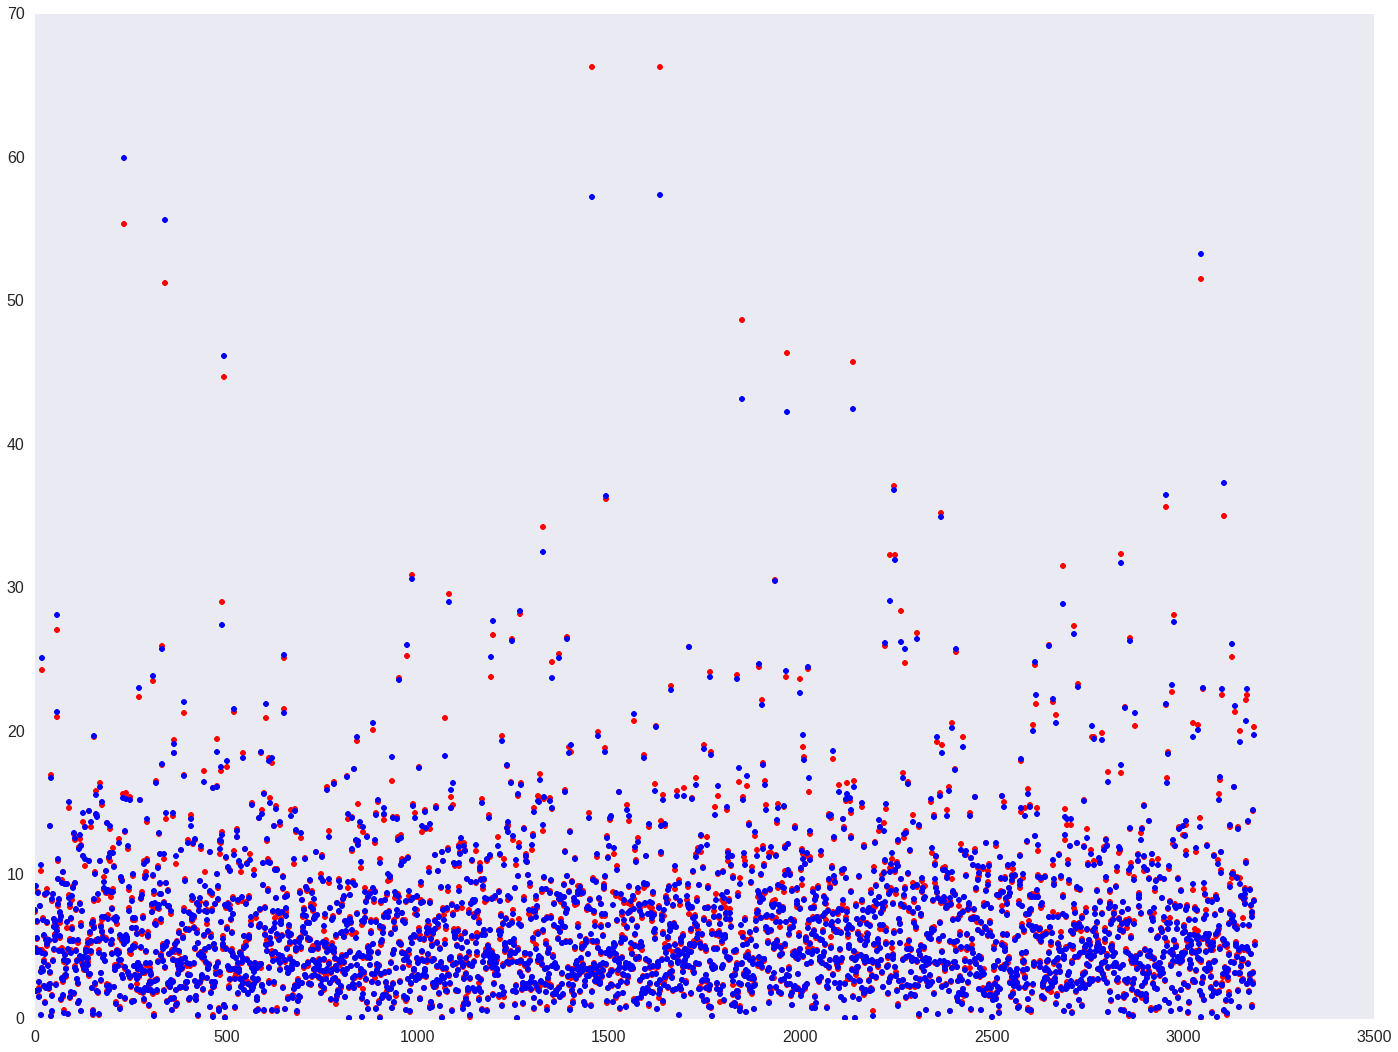

In [152]:
# index = sorted((rand(1000) * len(Y)).astype(int))
# index

sns.set(context='poster', style='dark')
pylab.rcParams['figure.figsize'] = (24.0, 18.0)


plt.plot(y_test, '.r')
plt.plot(gbr.predict(X_test), '.b')

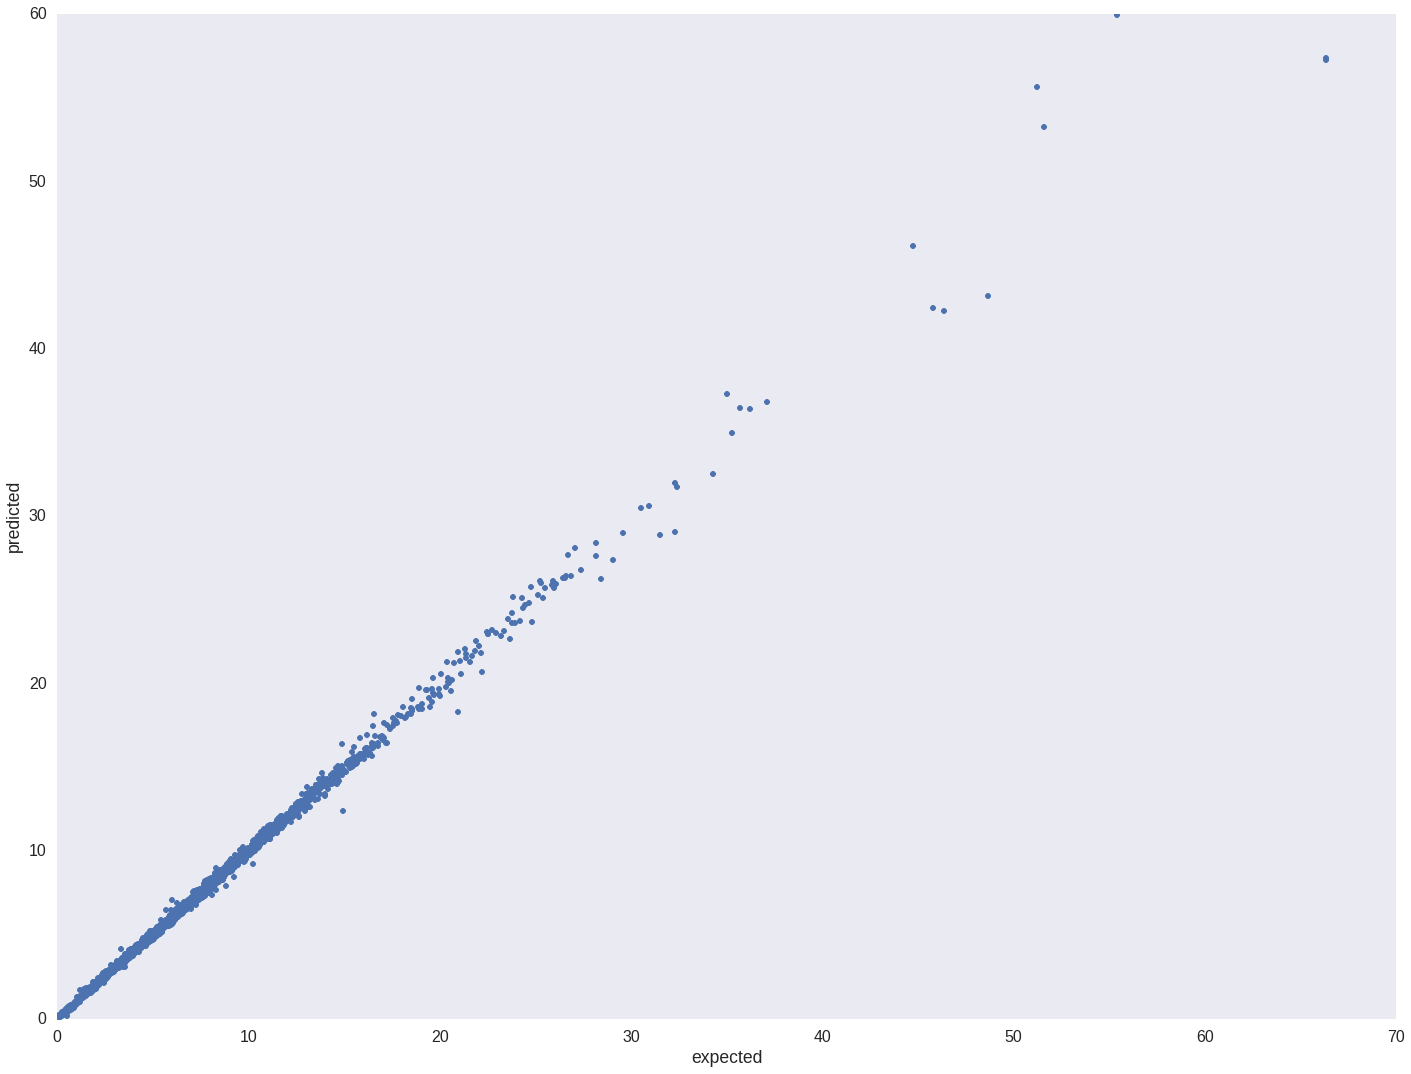

In [147]:
plt.plot(y_test, gbr.predict(X_test), '.')
plt.xlabel('expected')
plt.ylabel('predicted')

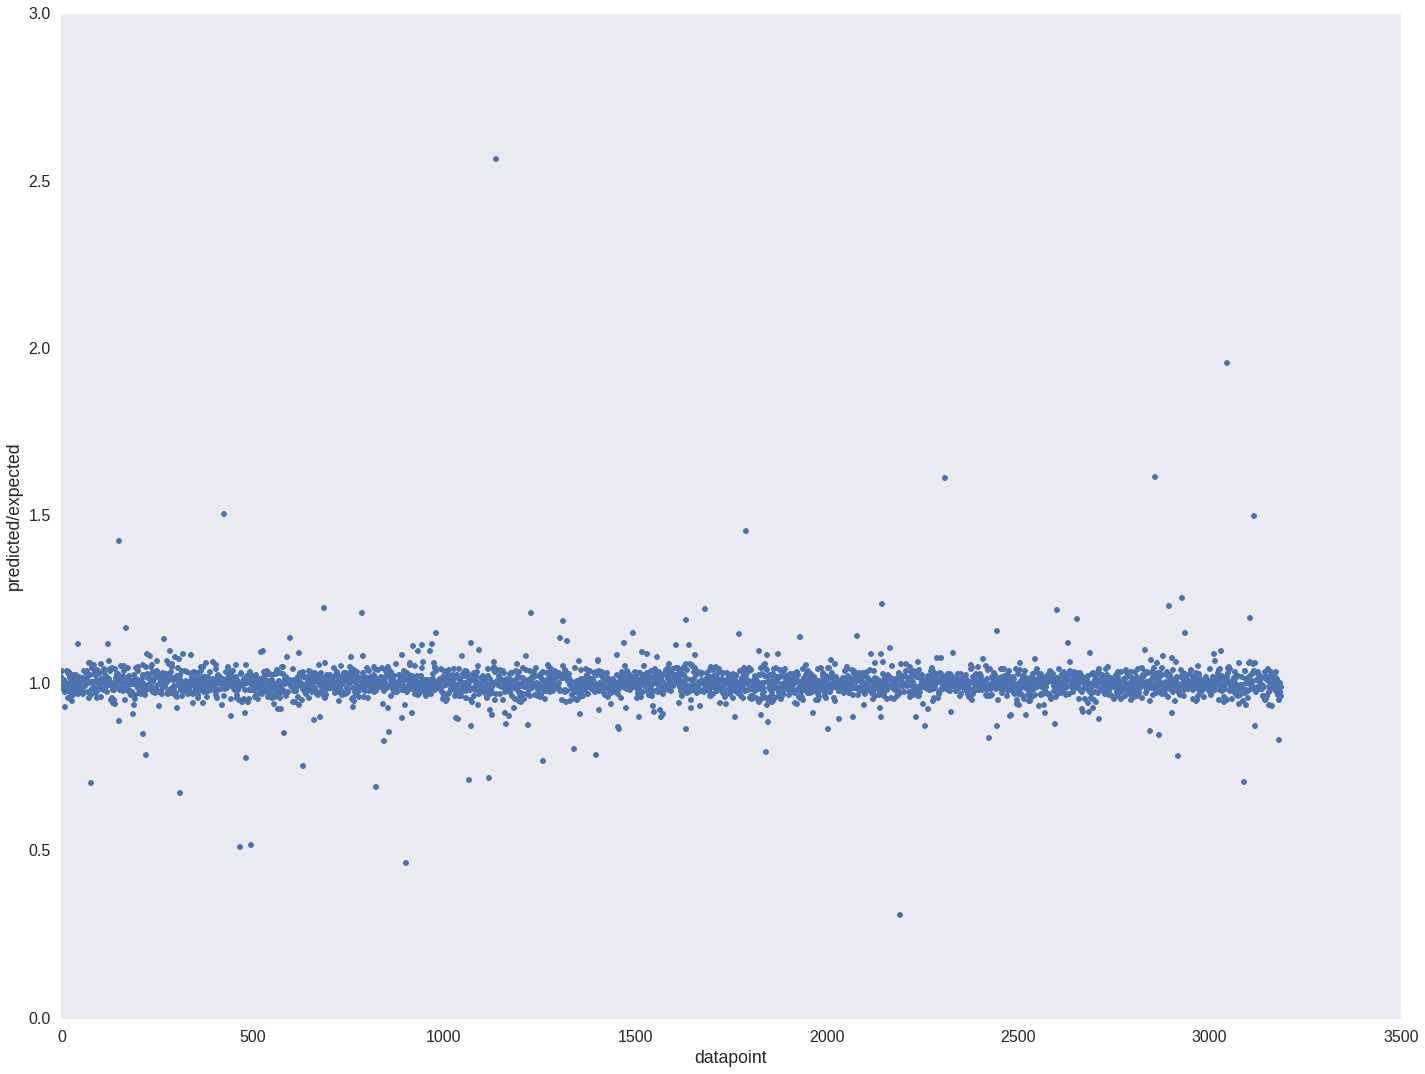

In [154]:
plt.plot(gbr.predict(X_test)/y_test, '.')
plt.ylabel('predicted/expected')
plt.xlabel('datapoint')

In [155]:
feat_imports = dict(zip(cols, gbr.feature_importances_))
import operator
sorted(feat_imports.items(), key=operator.itemgetter(1), reverse=True)

[('mouse_enc', 0.21865429816249923),
 ('mouse_min', 0.16137387056279334),
 ('key_enc', 0.085318976562368393),
 ('key_min', 0.06121483922732928),
 ('specialty_PCP_x_mouse_enc', 0.055449085884273323),
 ('provider_level_MD_x_mouse_enc', 0.044101746294075463),
 ('specialty_PCP_x_key_enc', 0.034703817031420413),
 ('specialty_PCP_x_mouse_min', 0.03113855368028667),
 ('provider_level_MD_x_key_enc', 0.025386654433373415),
 ('provider_level_MD_x_mouse_min', 0.022614436228189819),
 ('specialty_PCP_x_key_min', 0.01315336084268881),
 ('provider_level_MD_x_key_min', 0.012854024684574175),
 ('RVUs_enc', 0.012463798664482358),
 ('specialty_Surgery_x_mouse_enc', 0.011724934622516626),
 ('specialty_OB/GYN_x_mouse_enc', 0.011689158508839548),
 ('specialty_Surgery_x_key_enc', 0.011687326251106543),
 ('provider_level_Mid-level_x_key_enc', 0.011132359141875303),
 ('provider_level_Mid-level_x_mouse_enc', 0.010461764069280325),
 ('keystrokes', 0.0099443800136050781),
 ('mousestrokes', 0.008834465430785603),


In [78]:
from lasagne import layers

from lasagne.nonlinearities import softmax
from lasagne.updates import nesterov_momentum
from lasagne.nonlinearities import tanh
from lasagne.nonlinearities import sigmoid
from lasagne.nonlinearities import *
from lasagne.nonlinearities import identity

from nolearn.lasagne import NeuralNet

try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayer
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayer
except ImportError:
    Conv2DLayer = layers.Conv2DLayer
    MaxPool2DLayer = layers.MaxPool2DLayer

In [22]:
num_features=X.shape[1]
np.shape(X)

(15938, 63)

In [15]:
np.shape(Y)

(15938,)

In [96]:
X = np.float32(X)
Y = np.float32(Y)

y = Y.reshape((15938, 1))

In [101]:
print(np.shape(X))
print(np.shape(y))
print(y)

(15938, 63)
(15938, 1)
[[ 11.12250042]
 [ 11.54466152]
 [ 11.73053837]
 ..., 
 [  0.10061856]
 [  0.0957732 ]
 [  0.09392857]]


In [120]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = scaler.fit_transform(X)
X

array([[ 0.69177812, -0.42161793,  0.10916066, ..., -0.40173346,
        -0.49042198, -0.43319139],
       [ 0.72002095, -0.46107289,  0.22054294, ..., -0.40173346,
        -0.49042198, -0.43319139],
       [ 0.75919199, -0.45438841,  0.24568458, ..., -0.40173346,
        -0.49042198, -0.43319139],
       ..., 
       [-1.16484582,  4.75250626, -0.95760095, ..., -0.40173346,
        -0.49042198, -0.43319139],
       [-1.17528379,  3.99595666, -0.9581989 , ..., -0.40173346,
        -0.49042198, -0.43319139],
       [-1.15957713,  5.81618404, -0.9582212 , ..., -0.40173346,
        -0.49042198, -0.43319139]], dtype=float32)

In [162]:
np.mean(np.isnan(X))
np.mean(np.isnan(y))

0.0

In [130]:
y.mean()

6.6958966

In [132]:
X_rand = np.float32(rand(15938, 63)-0.5)
y_rand = np.float32(rand(15938, 1)*10)
X_rand.mean()
y_rand.mean()

5.0178251

In [134]:
layers0 = [('input', layers.InputLayer),
           ('dense0', layers.DenseLayer),
           ('dropout1', layers.DropoutLayer),
           ('dense1', layers.DenseLayer),
           ('dropout2', layers.DropoutLayer),
           ('dense2', layers.DenseLayer),
           ('output', layers.DenseLayer)]


net0 = NeuralNet(layers=layers0,
             input_shape=(None, num_features),
             dense0_num_units=200,  # 750 -> close to .47
             dropout1_p=0.1,
             dense1_num_units=200,
             dropout2_p=0.5,
             dense2_num_units=200,
             
             output_num_units=1,
             output_nonlinearity=None,
             update_learning_rate=0.01,
             update=nesterov_momentum,
             update_momentum=0.9,
             regression=True,
             eval_size=0.2,
             verbose=1,
             max_epochs=5)

net0.fit(X, y)

  input             	(None, 63)          	produces      63 outputs
  dense0            	(None, 200)         	produces     200 outputs
  dropout1          	(None, 200)         	produces     200 outputs
  dense1            	(None, 200)         	produces     200 outputs
  dropout2          	(None, 200)         	produces     200 outputs
  dense2            	(None, 200)         	produces     200 outputs
  output            	(None, 1)           	produces       1 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |         nan  |         nan  |          nan  |             |  4.2s
     2  |         nan  |         nan  |          nan  |             |  4.3s
     3  |         nan  |         nan  |          nan  |             |  4.3s
     4  |         nan  |         nan  |          nan  |             |  4.3s
     5  |         nan  |         nan  |          nan  |             |  4.4

NeuralNet(X_tensor_type=<function matrix at 0x7fc7799522f0>,
     batch_iterator_test=<nolearn.lasagne.BatchIterator object at 0x7fc7792ec5c0>,
     batch_iterator_train=<nolearn.lasagne.BatchIterator object at 0x7fc7792ec588>,
     dense0_num_units=200, dense1_num_units=200, dense2_num_units=200,
     dropout1_p=0.1, dropout2_p=0.5, eval_size=0.2, input_shape=(None, 63),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('dense0', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('dense1', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout2', <class 'lasagne.layers.noise.DropoutLayer'>), ('dense2', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=5, more_params={},
     objective=<class 'lasagne.objectives.Objective'>,
     objective_loss_function=<function mse at 0x7fc7792de268>,
     on_epoch_finished=(), on_training_finished=(),
   

In [157]:
net0.predict(X)

array([[ nan],
       [ nan],
       [ nan],
       ..., 
       [ nan],
       [ nan],
       [ nan]])

In [87]:
y

array([[ 11.12250042],
       [ 11.54466152],
       [ 11.73053837],
       ..., 
       [  0.10061856],
       [  0.0957732 ],
       [  0.09392857]], dtype=float32)